# Extend Hanna & Olken (2018) - Analysis
## Universal Basic Incomes versus Targeted Transfers: Anti-Poverty Programs in Developing Countries

Consider different budget levels, and a mix of UBI and targeted transfers.

## Setup

In [1]:
import pandas as pd
import numpy as np
import microdf as mdf
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# !wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
mdf.set_plot_style()

## Load data

Try loading locally first, otherwise load from GitHub.

In [3]:
F = 'sim.csv'
try:
    sim = pd.read_csv(F)
except:
    sim = pd.read_csv('https://github.com/MaxGhenis/hanna_olken/raw/master/' +
                      F)

## Visualize

In [4]:
SIMX = {
    'budget_share_of_gdp': [0.01, 0.1, 0.2, 0.5, 1, 5],
    'noise_col': ['y0_pr', 'y0_pr_l_noise', 'y0_pr_h_noise'],
    'pr_threshold': np.arange(0, 101, 1),
    'ubi_share': np.arange(0, 101, 1)
    }

### No UBI

Comparable to Hanna and Olken.

In [5]:
def single_plot(budget_share_of_gdp, ubi_share, noise):
    ax = sim[(sim.budget_share_of_gdp == budget_share_of_gdp) &
             (sim.ubi_share == ubi_share) &
             (sim.noise == noise)].plot('pr_threshold', 'crra')
    plt.title('CRRA by share given transfer, ' + str(budget_share_of_gdp) +
              '% of GDP, ' + noise, loc='left')
    plt.xlabel('Percent of households to which transfer is targeted')
    ax.get_xaxis().set_major_formatter(mpl.ticker.PercentFormatter())
    ax.set_yscale('symlog', linthreshy=-sim.crra.max())
    ax.get_legend().remove()
    plt.show()

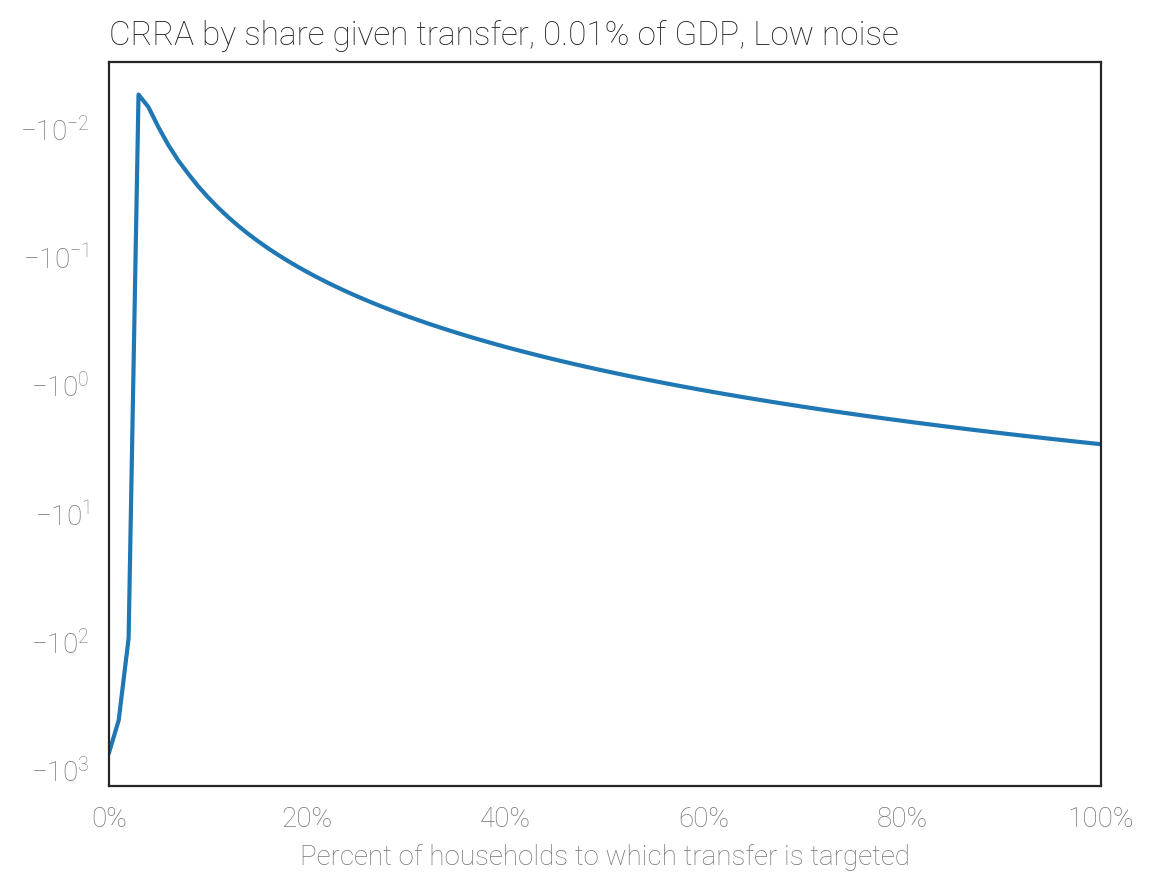

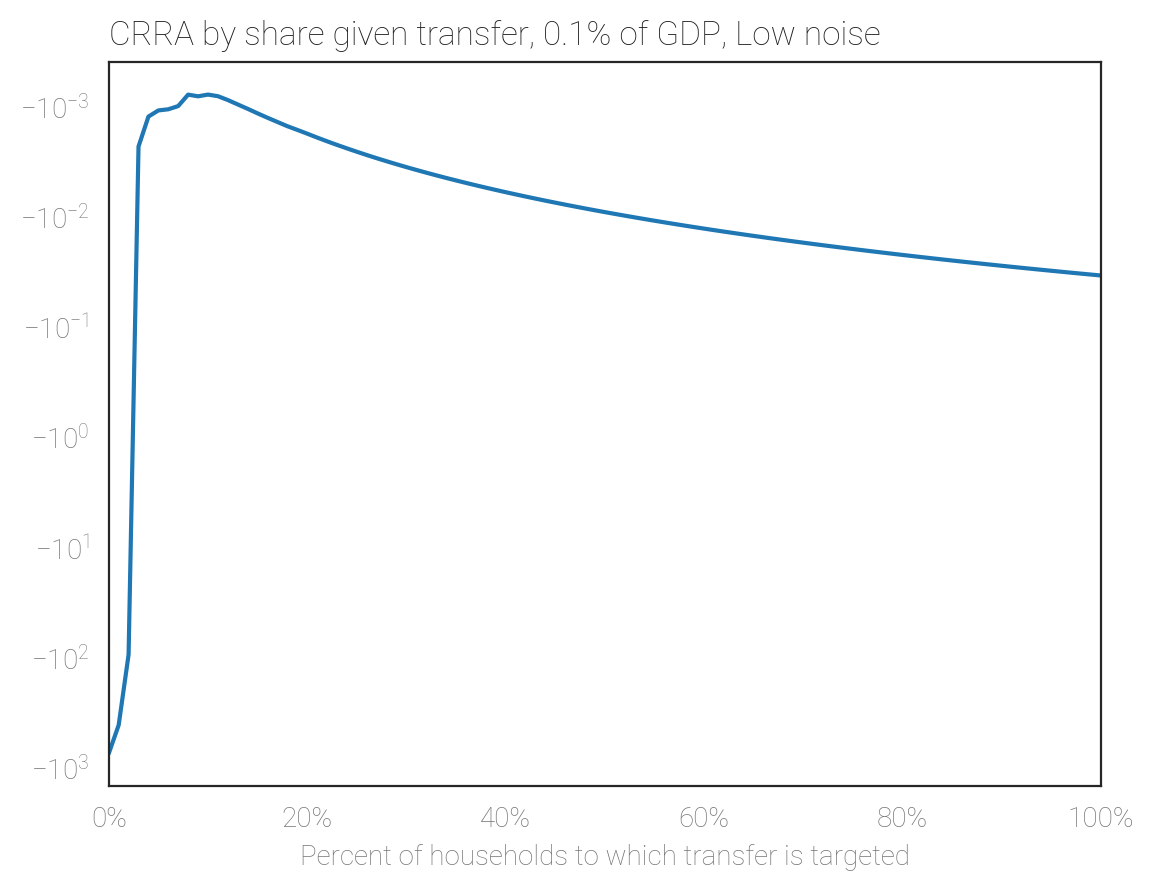

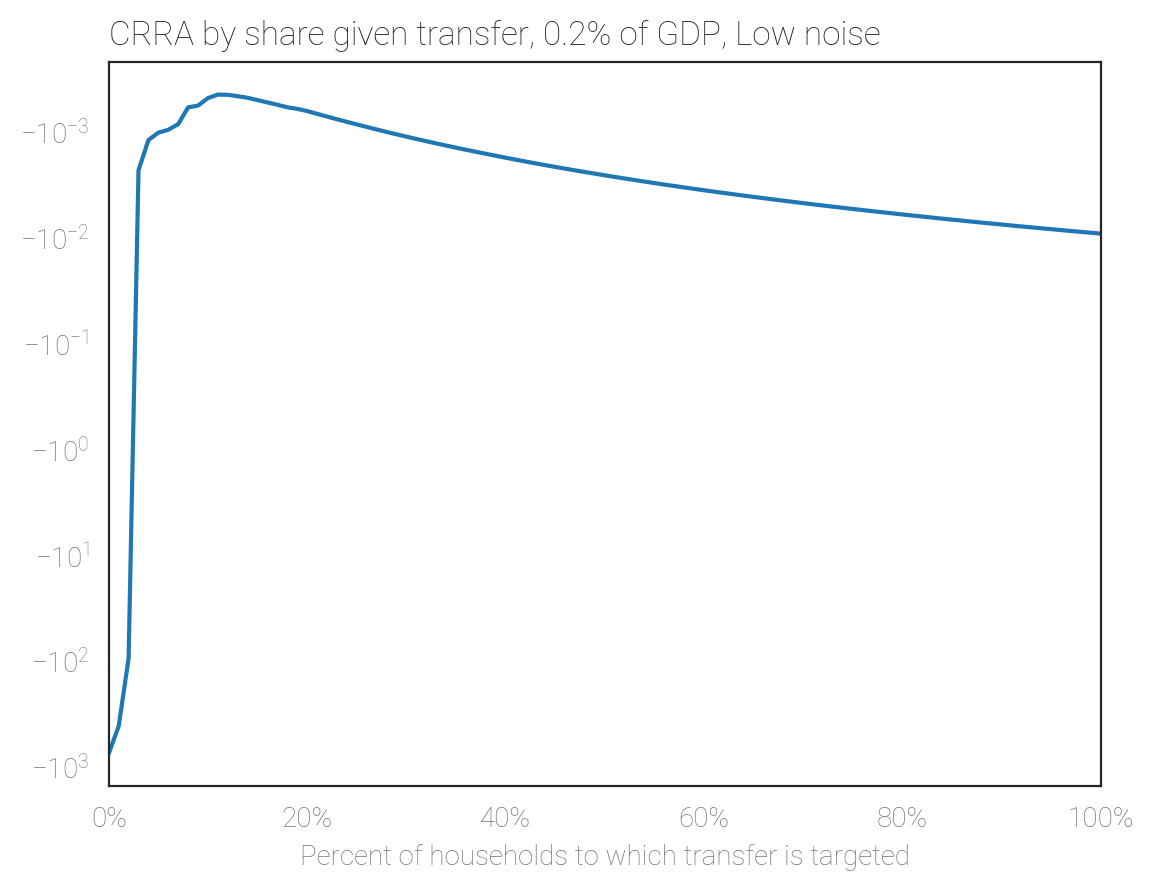

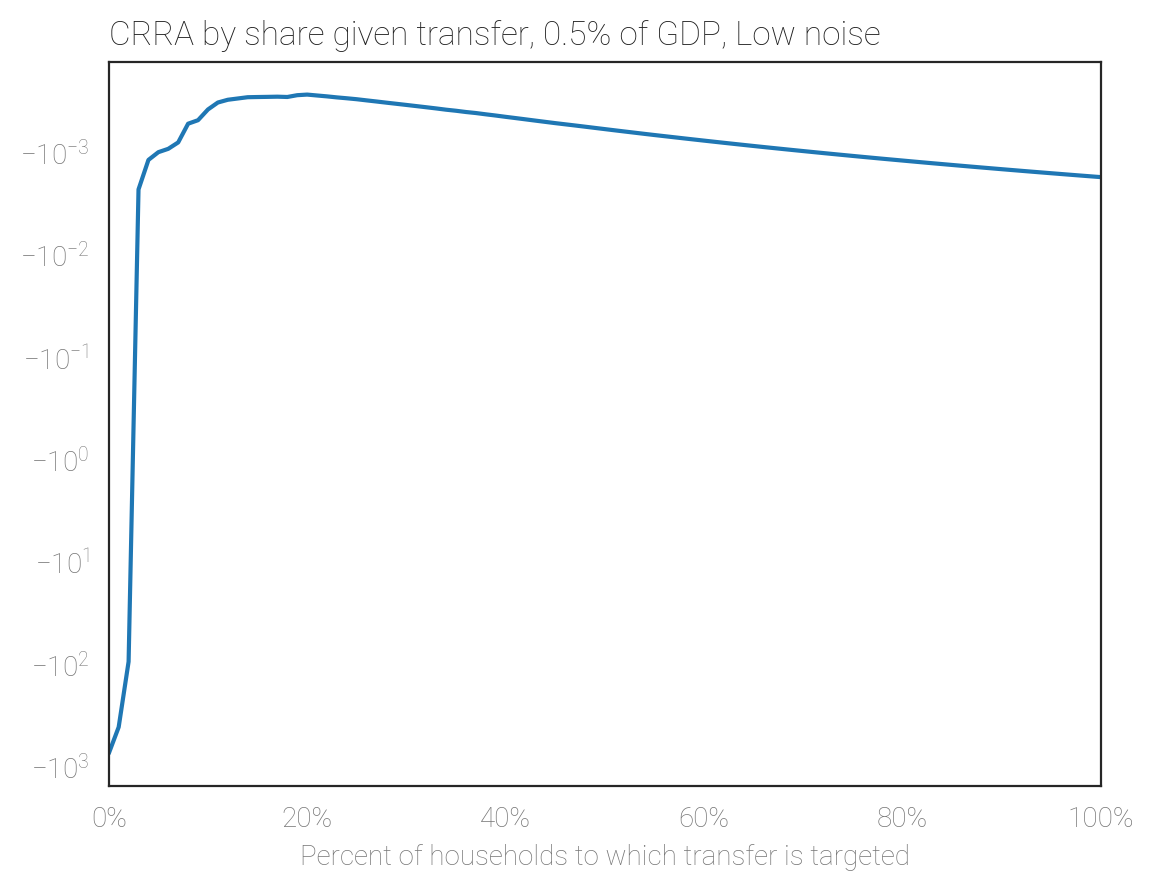

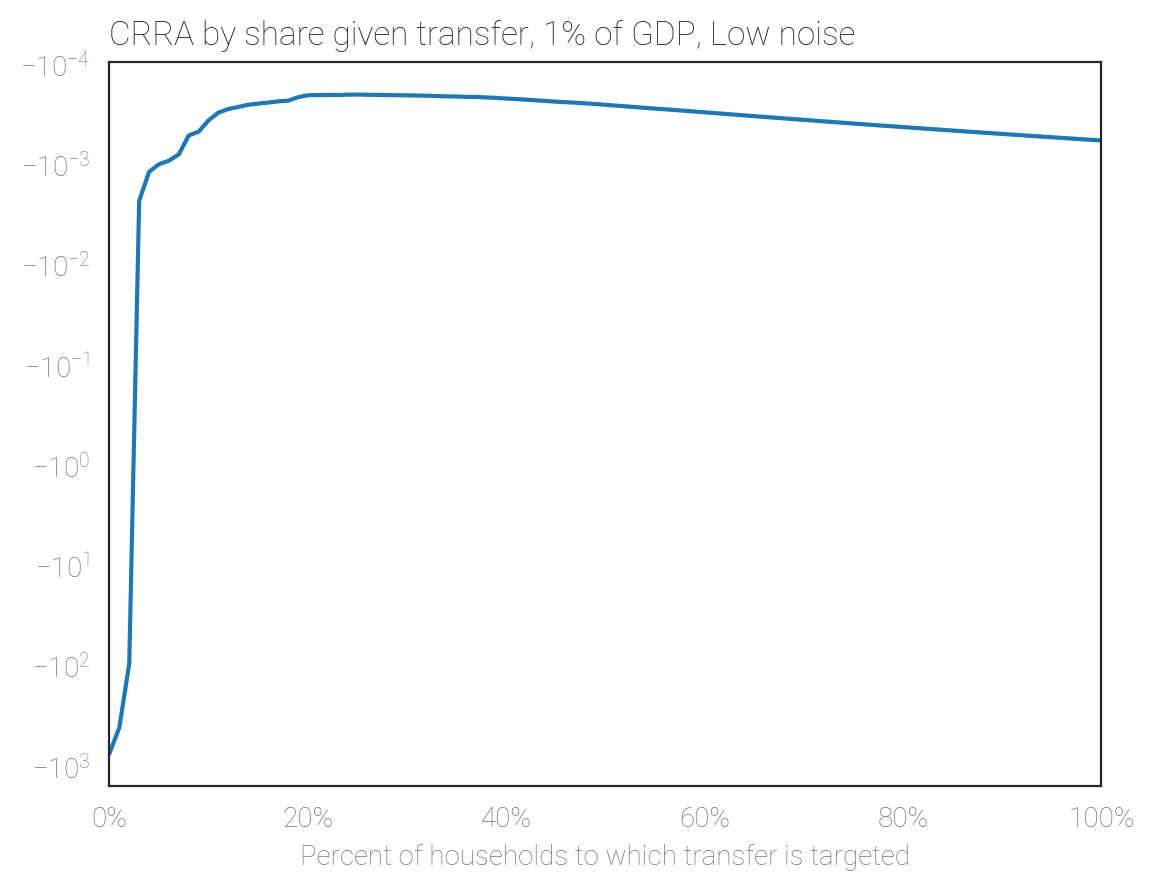

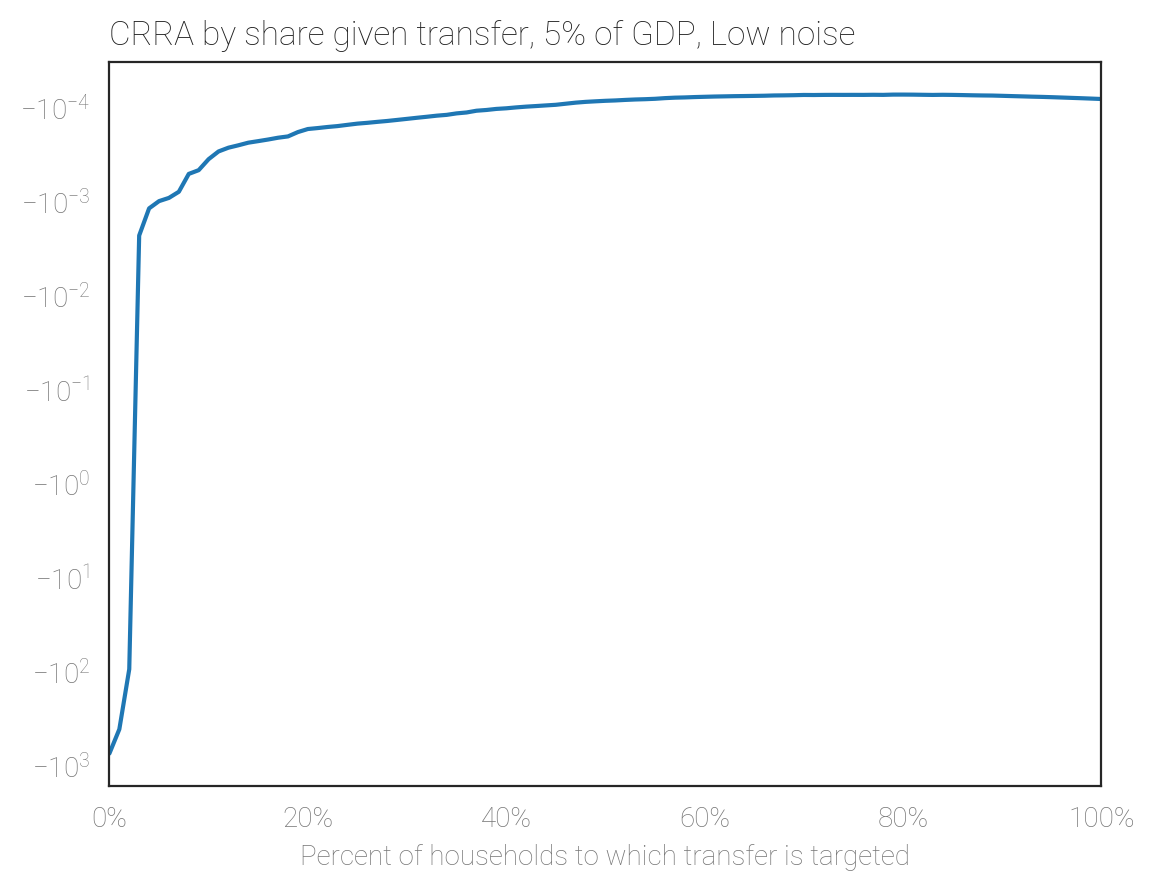

In [6]:
for budget in SIMX['budget_share_of_gdp']:
    single_plot(budget, 0, 'Low noise')

Single chart.

In [7]:
def plot_by_budget(ubi_share, noise):
    by_budget = sim[(sim.ubi_share == ubi_share) &
                    (sim.noise == noise)].pivot(
                        'pr_threshold', 'budget_share_of_gdp', 'crra')
    ax = by_budget.plot()
    plt.title('CRRA by share given transfer and program size, ' + noise,
              loc='left')
    plt.xlabel('Percent of households to which transfer is targeted')
    ax.get_xaxis().set_major_formatter(mpl.ticker.PercentFormatter())
    ax.set_yscale('symlog', linthreshy=-sim.crra.max())
    ax.legend([str(i) + '%' for i in by_budget.columns], title='Share of GDP')
    plt.show()

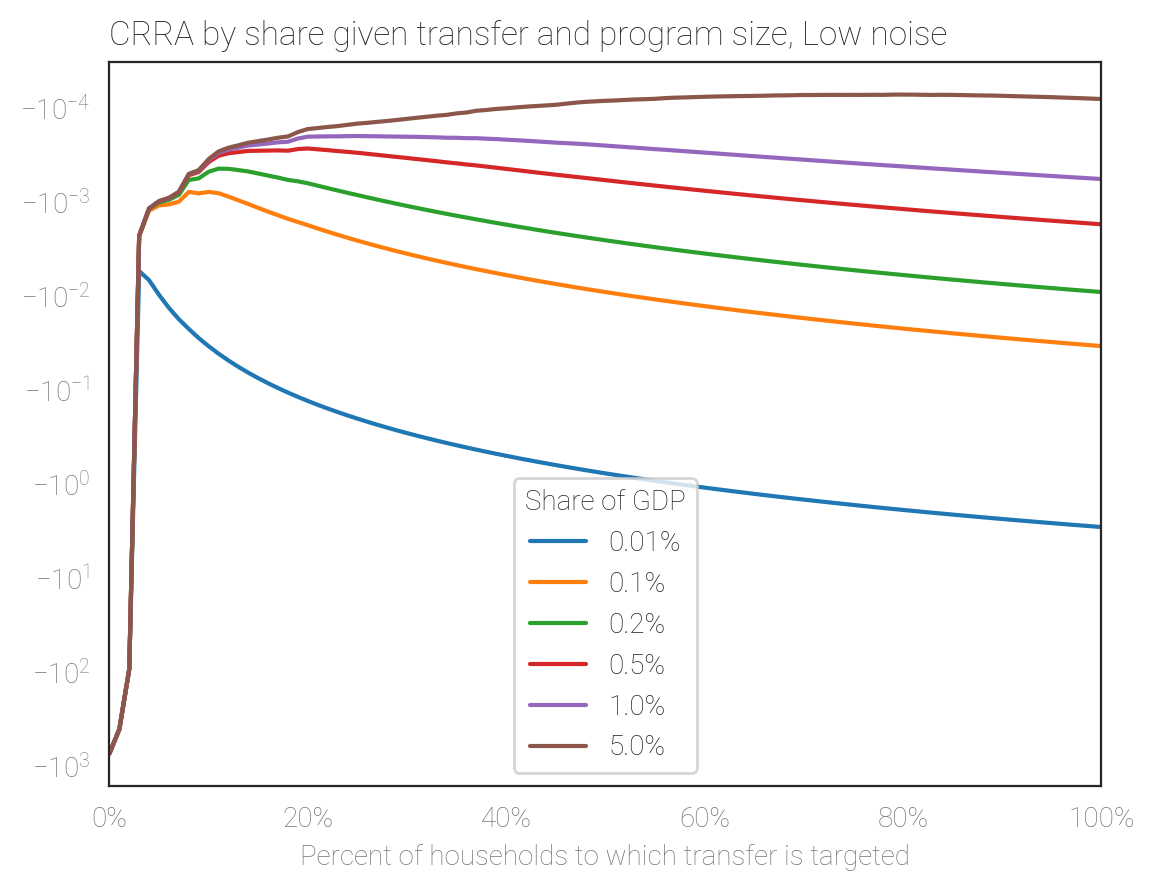

In [8]:
plot_by_budget(0, 'Low noise')

### Optimal targeting by condition

#### No UBI

In [9]:
optimal_targeting_no_ubi = sim[sim.ubi_share == 0].sort_values(
    'crra', ascending=False).drop_duplicates(
        ['budget_share_of_gdp', 'noise']).sort_values(
            ['budget_share_of_gdp', 'noise']).set_index(
                ['budget_share_of_gdp', 'noise']).drop('ubi_share', axis=1)

In [10]:
optimal_targeting_no_ubi_join = optimal_targeting_no_ubi.copy(deep=True)
optimal_targeting_no_ubi_join.columns = pd.MultiIndex.from_product(
    [['No UBI'], optimal_targeting_no_ubi.columns.tolist()])

In [11]:
optimal_targeting_no_ubi_pivot = optimal_targeting_no_ubi.reset_index().pivot(
    'budget_share_of_gdp', 'noise', ['pr_threshold', 'crra'])

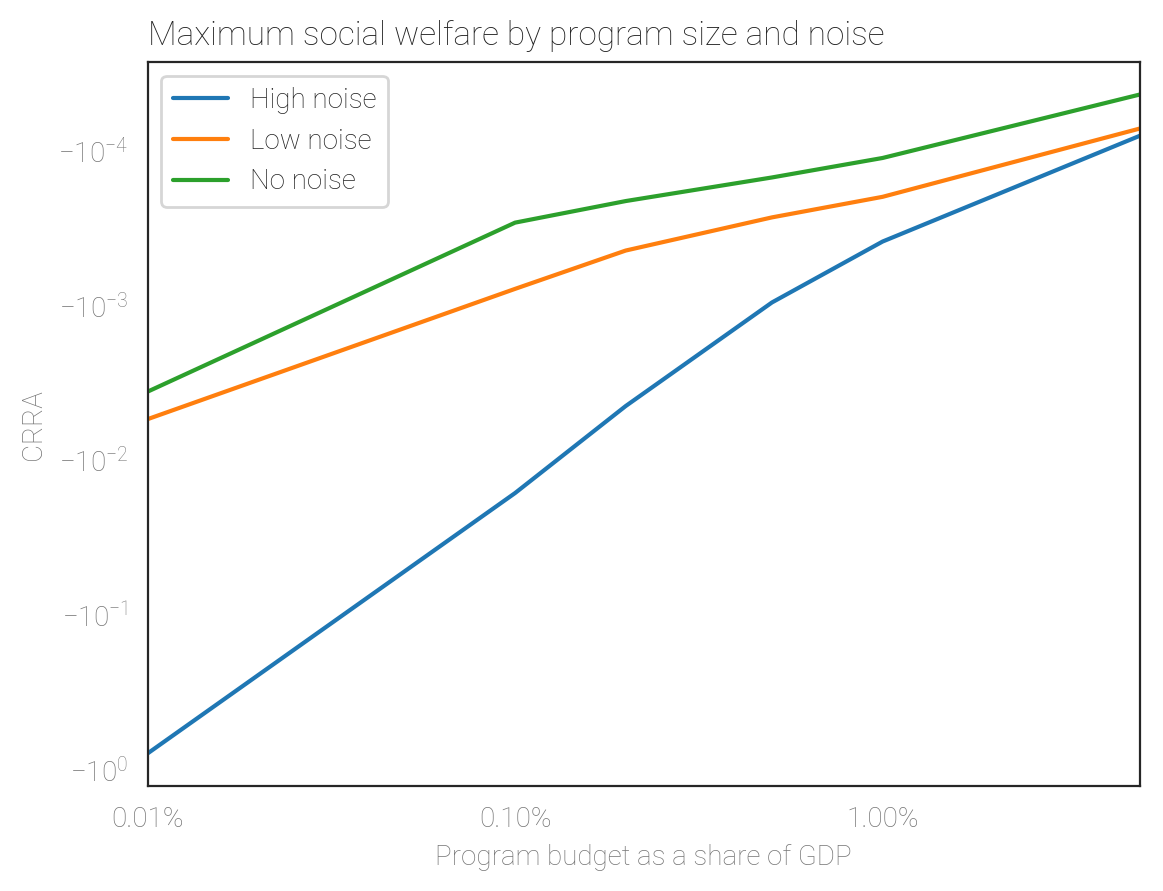

In [12]:
ax = optimal_targeting_no_ubi_pivot.crra.plot()
plt.title('Maximum social welfare by program size and noise', loc='left')
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(mpl.ticker.PercentFormatter())
plt.xlabel('Program budget as a share of GDP')
plt.ylabel('CRRA')
ax.set_yscale('symlog', linthreshy=-sim.crra.max())
plt.legend(title='')
plt.show()

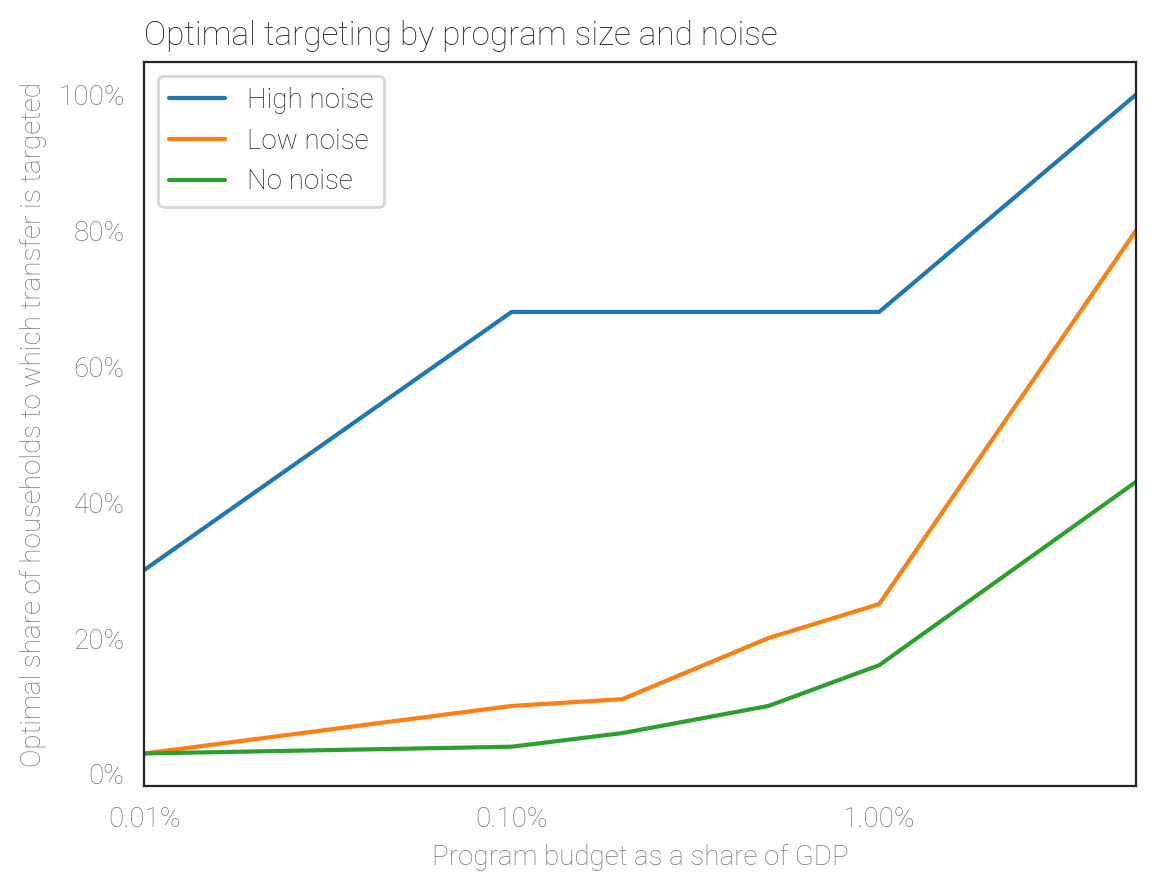

In [13]:
ax = optimal_targeting_no_ubi_pivot.pr_threshold.plot()
plt.title('Optimal targeting by program size and noise', loc='left')
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(mpl.ticker.PercentFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.PercentFormatter())
plt.xlabel('Program budget as a share of GDP')
plt.ylabel('Optimal share of households to which transfer is targeted')
plt.legend(title='')
plt.show()

#### With UBI

In [14]:
optimal_targeting_ubi = sim.sort_values(
    'crra', ascending=False).drop_duplicates(
        ['budget_share_of_gdp', 'noise']).sort_values(
            ['budget_share_of_gdp', 'noise']).set_index(
                ['budget_share_of_gdp', 'noise'])

In [15]:
optimal_targeting_ubi_join = optimal_targeting_ubi.copy(deep=True)
optimal_targeting_ubi_join.columns = pd.MultiIndex.from_product(
    [['With UBI'], optimal_targeting_ubi.columns.tolist()])

In [16]:
optimal_targeting_joined = optimal_targeting_no_ubi_join.join(optimal_targeting_ubi_join)
optimal_targeting_joined['improvement'] = 1 - optimal_targeting_joined['With UBI'].crra / optimal_targeting_joined['No UBI'].crra
optimal_targeting_joined

No UBI                             \
                               pr_threshold targeted_amount ubi_amount   
budget_share_of_gdp noise                                                
0.01                High noise           30       50.465437        0.0   
                    Low noise             3      504.708198        0.0   
                    No noise              3      504.995002        0.0   
0.10                High noise           68      222.640571        0.0   
                    Low noise            10     1514.205679        0.0   
                    No noise              4     3786.441829        0.0   
0.20                High noise           68      445.281141        0.0   
                    Low noise            11     2752.665283        0.0   
                    No noise              6     5047.329840        0.0   
0.50                High noise           68     1113.202854        0.0   
                    Low noise            20     3785.121651        0.0   
                    No noise             10     7571.473146        0.0   
1.00                High noise           68     2226.405707        0.0   
                    Low noise            25     6055.967689        0.0   
                    No noise             16     9462.740640        0.0   
5.00                High noise          100     7569.903019        0.0   
                    Low noise            80     9462.362599        0.0   
                    No noise             43    17604.144399        0.0   

                                             With UBI            \
                                    crra pr_threshold ubi_share   
budget_share_of_gdp noise                                         
0.01                High noise -0.790044           17        35   
                    Low noise  -0.005451            3         0   
                    No noise   -0.003620            3         0   
0.10                High noise -0.016367           14        49   
                    Low noise  -0.000784            8         3   
                    No noise   -0.000292            4         0   
0.20                High noise -0.004482           14        52   
                    Low noise  -0.000443           11         0   
                    No noise   -0.000212            6         0   
0.50                High noise -0.000959           12        63   
                    Low noise  -0.000270           20         0   
                    No noise   -0.000149           10         0   
1.00                High noise -0.000387           12        70   
                    Low noise  -0.000199           20        25   
                    No noise   -0.000112           16         0   
5.00                High noise -0.000080           19        84   
                    Low noise  -0.000072           25        73   
                    No noise   -0.000043           43         0   

                                                                       \
                               targeted_amount   ubi_amount      crra   
budget_share_of_gdp noise                                               
0.01                High noise       57.887565     5.298778 -0.278613   
                    Low noise       504.708198     0.000000 -0.005451   
                    No noise        504.995002     0.000000 -0.003620   
0.10                High noise      551.541458    74.182887 -0.004304   
                    Low noise      1835.938630     4.541809 -0.000782   
                    No noise       3786.441829     0.000000 -0.000292   
0.20                High noise     1038.195686   157.449393 -0.001491   
                    Low noise      2752.665283     0.000000 -0.000443   
                    No noise       5047.329840     0.000000 -0.000212   
0.50                High noise     2334.251298   476.889988 -0.000499   
                    Low noise      3785.121651     0.000000 -0.000270   
                    No noise       7571.473146     0

In [17]:
optimal_targeting_joined.to_csv('optimal_targeting.csv', index=True)

### Graphs by noise level

In [18]:
def plot_by_noise(budget_share_of_gdp, ubi_share):
    by_noise = sim[(sim.budget_share_of_gdp == budget_share_of_gdp) &
                   (sim.ubi_share == ubi_share)].pivot(
                        'pr_threshold', 'noise', 'crra')
    ax = by_noise.plot()
    plt.title('CRRA by share given transfer and noise, ' + 
              str(budget_share_of_gdp) + '% of GDP',
              loc='left')
    plt.xlabel('Percent of households to which transfer is targeted')
    ax.get_xaxis().set_major_formatter(mpl.ticker.PercentFormatter())
    ax.set_yscale('symlog', linthreshy=-sim.crra.max())
    ax.legend(title='')
    plt.show()

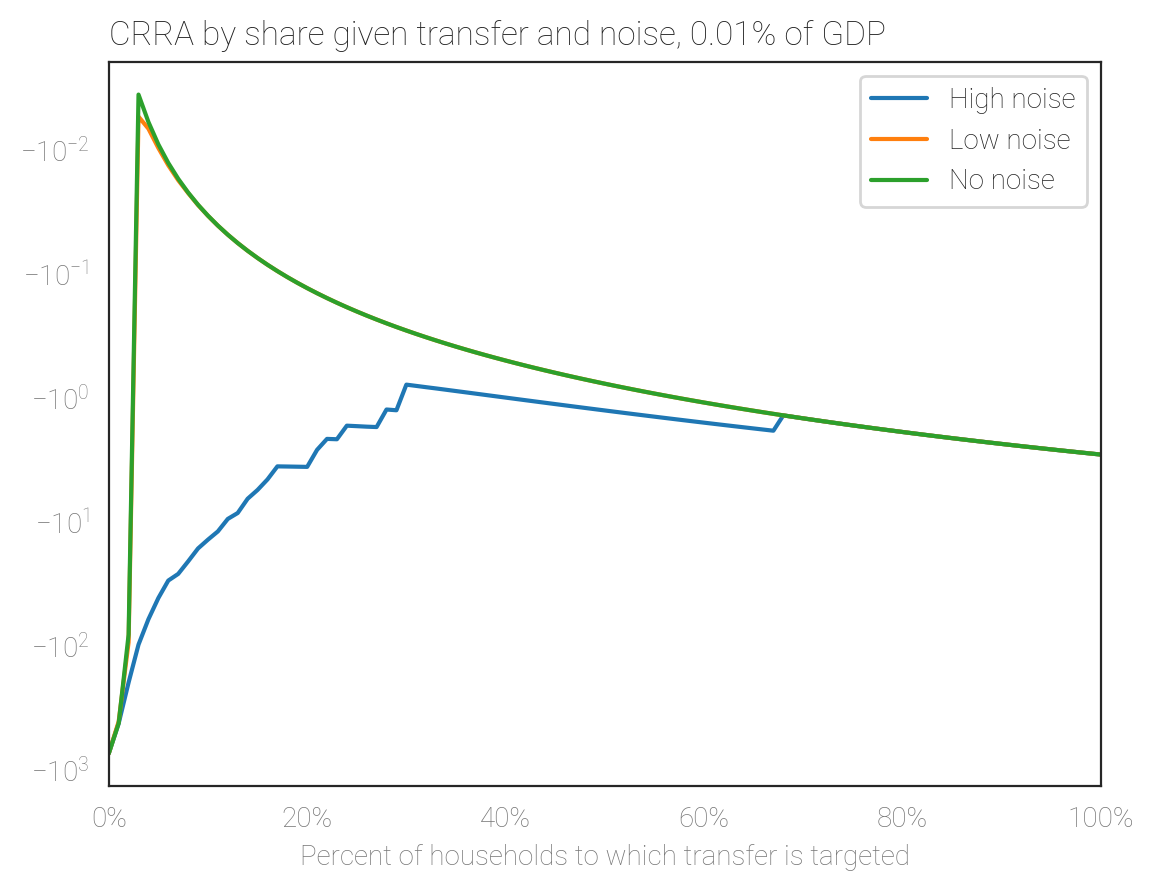

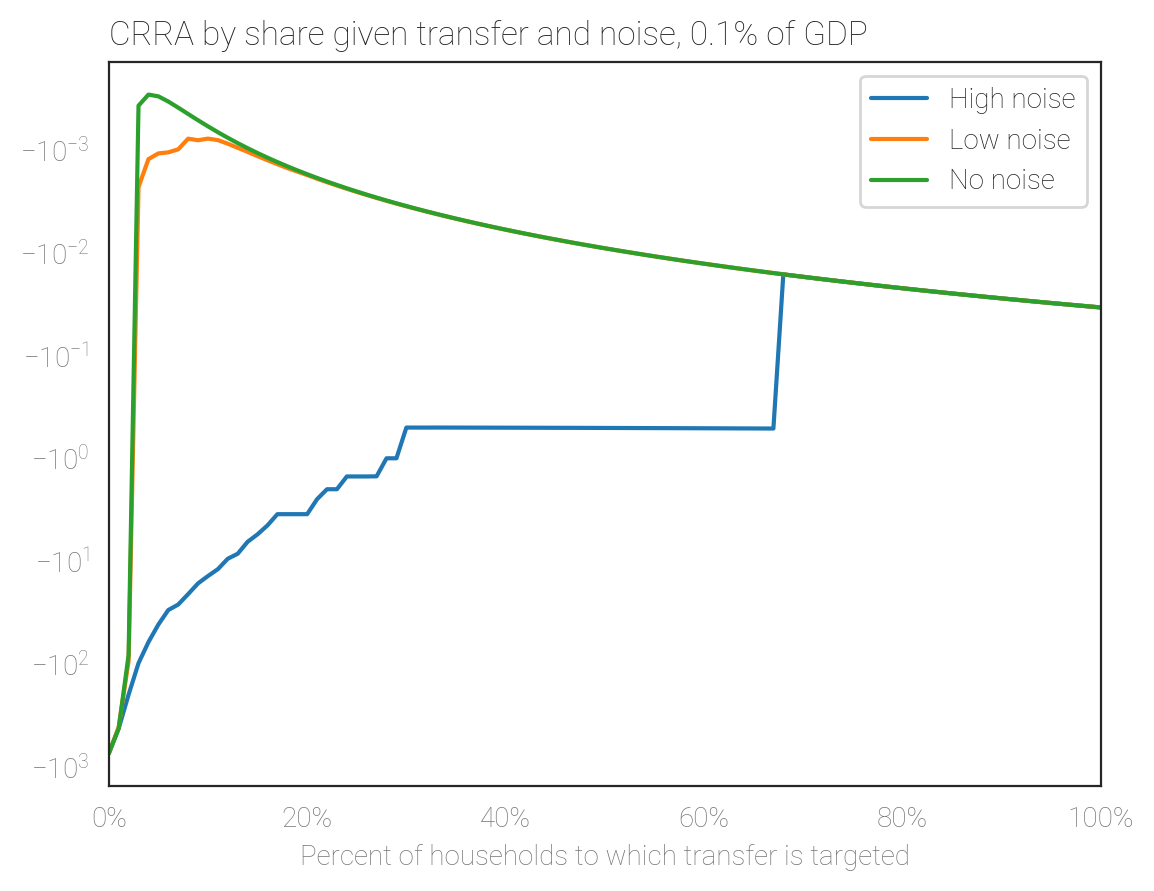

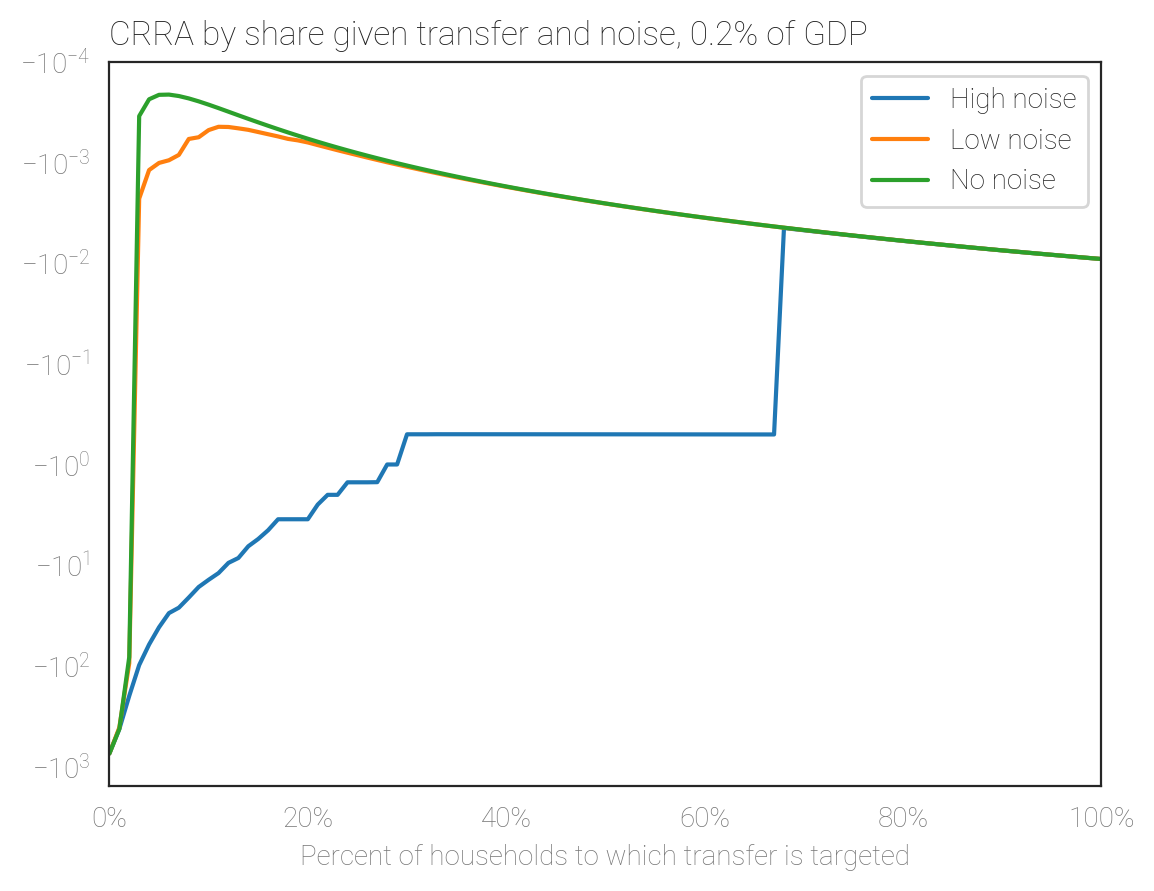

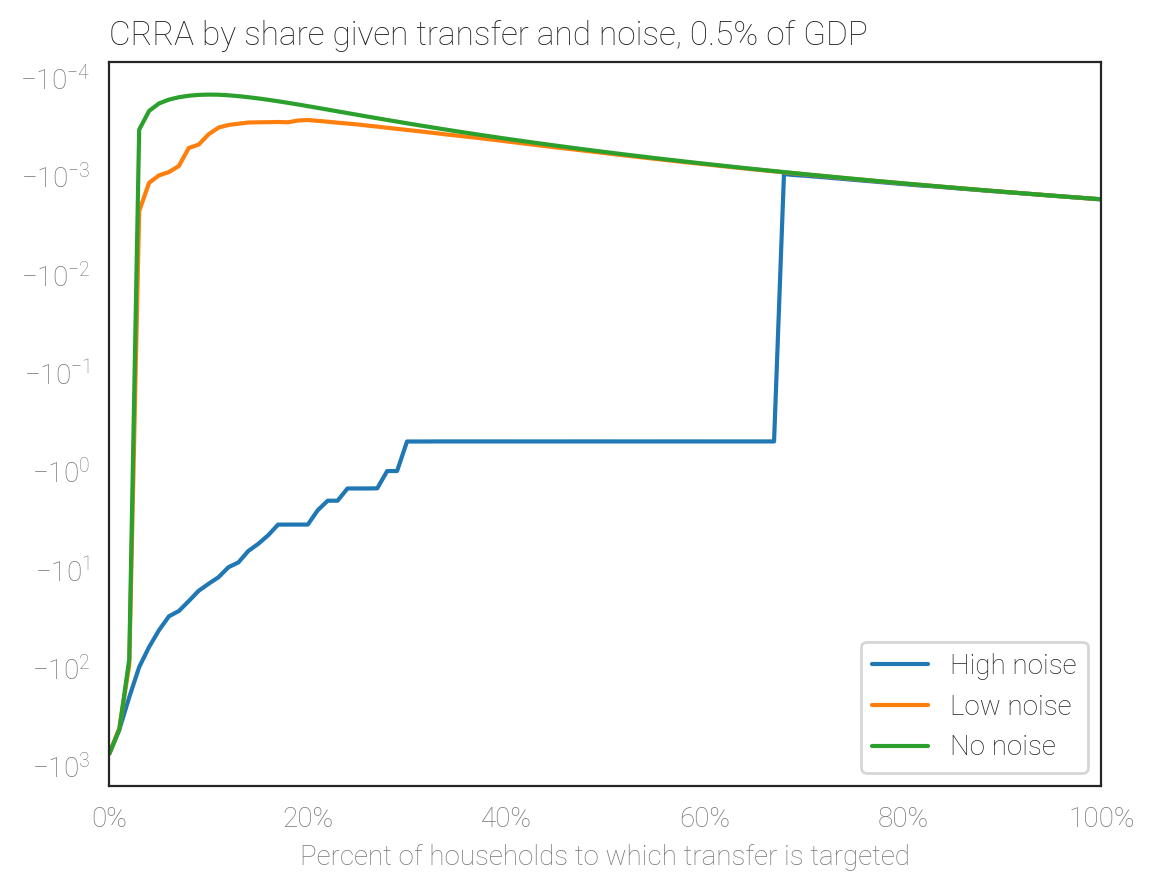

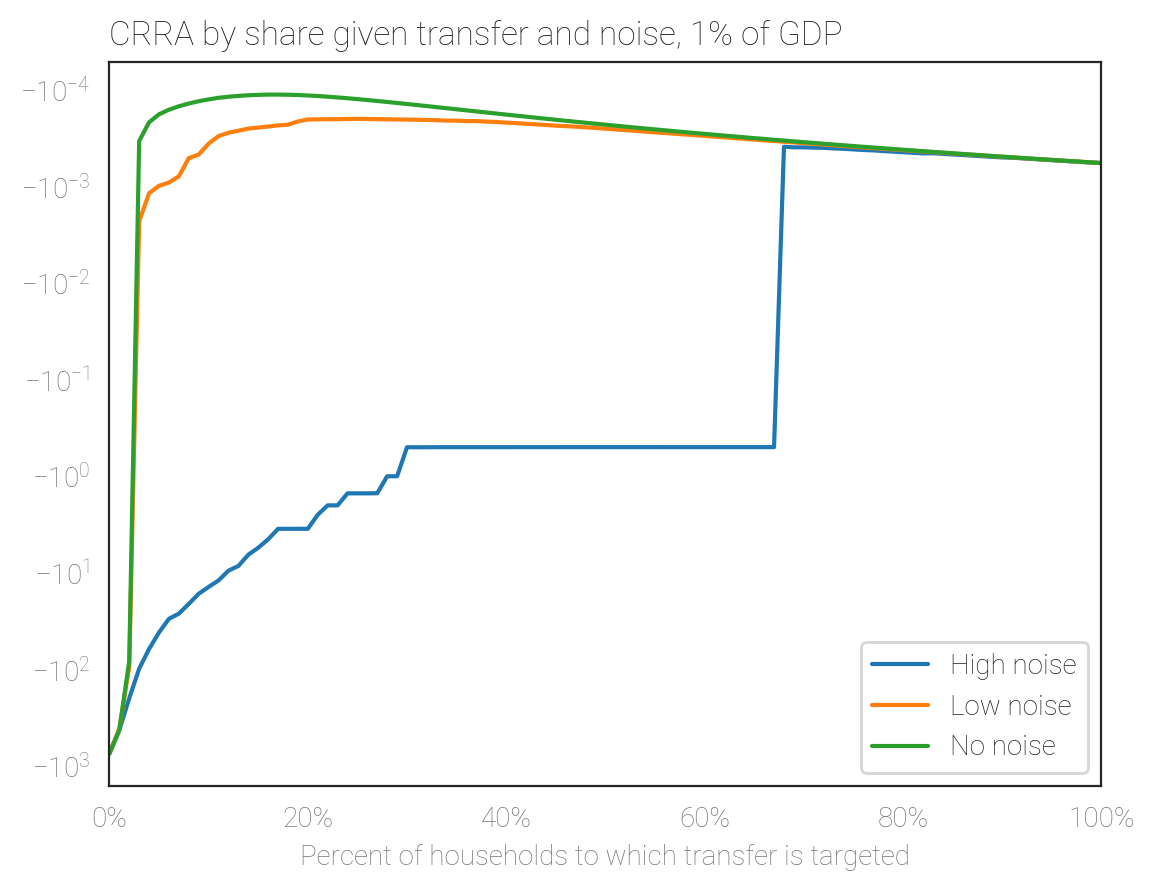

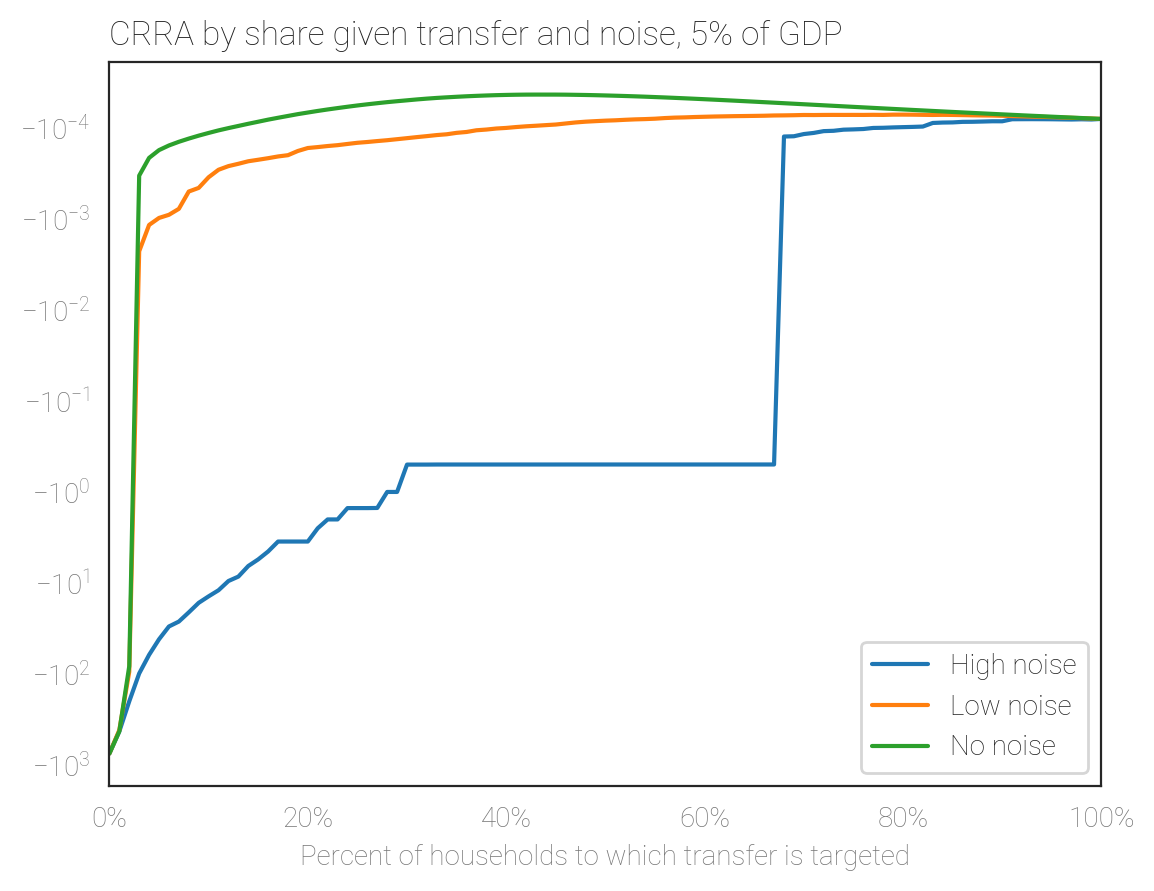

In [19]:
for budget in SIMX['budget_share_of_gdp']:
    plot_by_noise(budget, 0)

### Graphs with UBI

Improvement when allowing for a UBI share.

In [20]:
improvement_plot = optimal_targeting_joined.improvement.reset_index().pivot(
    'budget_share_of_gdp', 'noise', 'improvement'
)
improvement_plot *= 100  # For plotting.
improvement_plot

noise,High noise,Low noise,No noise
budget_share_of_gdp,,,
0.01,64.734491,0.000000,0.0
0.10,73.706000,0.163088,0.0
0.20,66.724172,0.000000,0.0
0.50,47.952804,0.000000,0.0
1.00,30.861494,3.489644,0.0
5.00,11.465953,8.313828,0.0


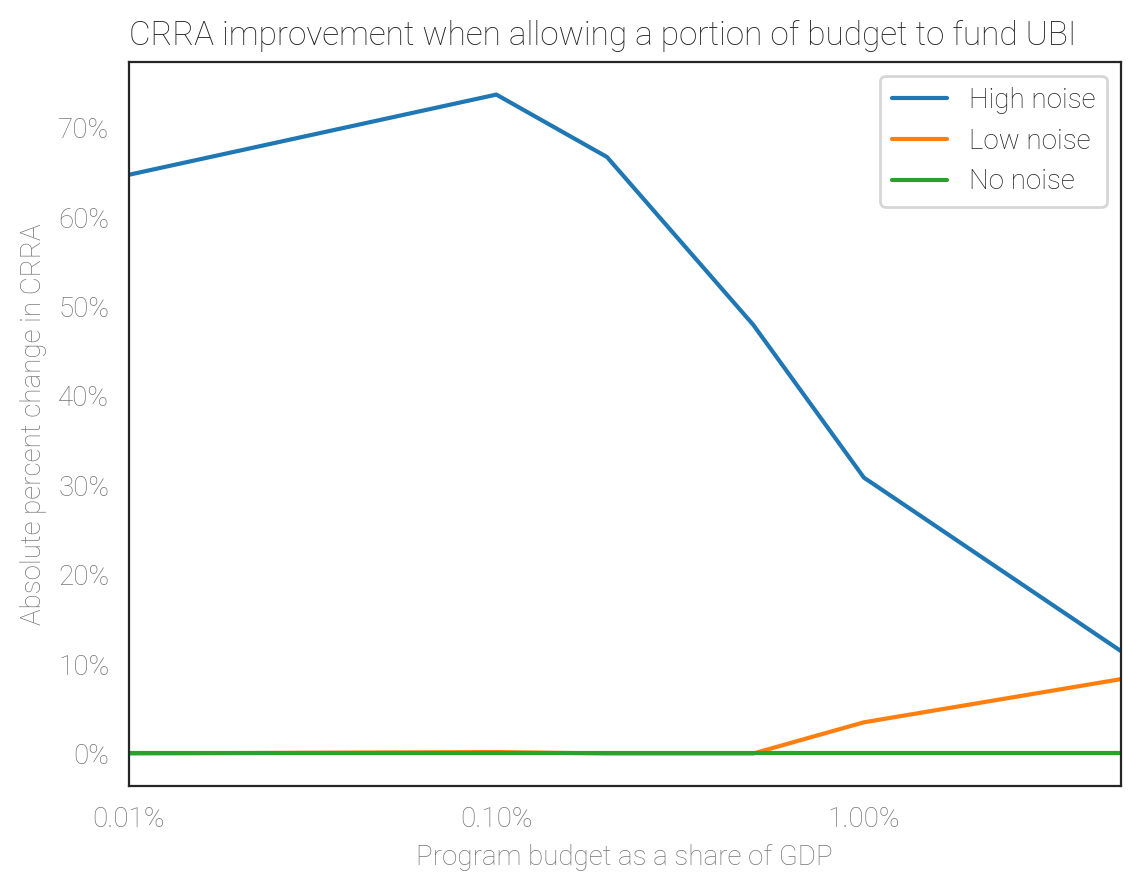

In [21]:
ax = improvement_plot.plot()
plt.title('CRRA improvement when allowing a portion of budget to fund UBI',
          loc='left')
plt.xlabel('Program budget as a share of GDP')
plt.ylabel('Absolute percent change in CRRA')
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(mpl.ticker.PercentFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.PercentFormatter())
ax.legend(title='')
plt.show()